<a href="https://colab.research.google.com/github/siting1206/NLP_HW1/blob/main/Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from collections import namedtuple
from tensorflow.keras.preprocessing.sequence import pad_sequences

import regex as re
import os, string, sys

from gensim.models.word2vec import Word2Vec

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
class RegexFeatures(object):
    PATTERNS = {
        "isInitCapitalWord": re.compile(r'^[A-Z][a-z]+'),
        "isAllCapitalWord": re.compile(r'^[A-Z][A-Z]+$'),
        "isAllSmallCase": re.compile(r'^[a-z]+$'),
        "isWord": re.compile(r'^[a-zA-Z][a-zA-Z]+$'),
        "isAlphaNumeric": re.compile(r'^\p{Alnum}+$'),
        "isSingleCapLetter": re.compile(r'^[A-Z]$'),
        "containsDashes": re.compile(r'.*--.*'),
        "containsDash": re.compile(r'.*\-.*'),
        "singlePunctuation": re.compile(r'^\p{Punct}$'),
        "repeatedPunctuation": re.compile(r'^[\.\,!\?"\':;_\-]{2,}$'),
        "singleDot": re.compile(r'[.]'),
        "singleComma": re.compile(r'[,]'),
        "singleQuote": re.compile(r'[\']'),
        "isSpecialCharacter": re.compile(r'^[#;:\-/<>\'\"()&]$'),
        "fourDigits": re.compile(r'^\d\d\d\d$'),
        "isDigits": re.compile(r'^\d+$'),
        "isNumber": re.compile(r'^((\p{N}{,2}([,]?\p{N}{3})+)(\.\p{N}+)?)$'),
        "containsDigit": re.compile(r'.*\d+.*'),
        "endsWithDot": re.compile(r'\p{Alnum}+\.$'),
        "isURL": re.compile(r'^http[s]?://'),
        "isMention": re.compile(r'^(RT)?@[\p{Alnum}_]+$'),
        "isHashtag": re.compile(r'^#\p{Alnum}+$'),
        "isMoney": re.compile(r'^\$((\p{N}{,2}([,]?\p{N}{3})+)(\.\p{N}+)?)$'),
    }
    def __init__(self):
        print("Initialized RegexFeature")
    def process(word):
        features = dict()
        for k, p in RegexFeatures.PATTERNS.iteritems():
            if p.match(word):
                features[k] = True
        return features


Tag = namedtuple("Tag", ["token", "tag"])

def load_sequences(filename, sep="\t", notypes=False, test_data=False):
    sequences = []
    with open(filename) as fp:
        seq = []
        for line in fp:
            line = line.strip()
            if line:
                line = line.split(sep)
                seq.append(Tag(*line))
            else:
                sequences.append(seq)
                seq = []
        if seq:
            sequences.append(seq)
    return sequences

In [59]:
train_sequences = load_sequences("drive/MyDrive/NLP_assignment1/data/train.txt", sep="\t", notypes=True)
print(train_sequences)
dev_sequences = load_sequences("drive/MyDrive/NLP_assignment1/data/dev.txt", sep="\t", notypes=False)

test_sequences = open("drive/MyDrive/NLP_assignment1/data/test-submit.txt", 'r')
test_sequences = test_sequences.readlines() 
X_test = [x.strip() for x in test_sequences]

[[Tag(token='@SammieLynnsMom', tag='O'), Tag(token='@tg10781', tag='O'), Tag(token='they', tag='O'), Tag(token='will', tag='O'), Tag(token='be', tag='O'), Tag(token='all', tag='O'), Tag(token='done', tag='O'), Tag(token='by', tag='O'), Tag(token='Sunday', tag='O'), Tag(token='trust', tag='O'), Tag(token='me', tag='O'), Tag(token='*wink*', tag='O')], [Tag(token='Made', tag='O'), Tag(token='it', tag='O'), Tag(token='back', tag='O'), Tag(token='home', tag='O'), Tag(token='to', tag='O'), Tag(token='GA', tag='B-geo-loc'), Tag(token='.', tag='O'), Tag(token='It', tag='O'), Tag(token='sucks', tag='O'), Tag(token='not', tag='O'), Tag(token='to', tag='O'), Tag(token='be', tag='O'), Tag(token='at', tag='O'), Tag(token='Disney', tag='B-facility'), Tag(token='world', tag='I-facility'), Tag(token=',', tag='O'), Tag(token='but', tag='O'), Tag(token='its', tag='O'), Tag(token='good', tag='O'), Tag(token='to', tag='O'), Tag(token='be', tag='O'), Tag(token='home', tag='O'), Tag(token='.', tag='O'), Tag

In [60]:
train_sentences = [[t[0] for t in seq] for seq in (train_sequences)]
train_tags = [[t[1] for t in seq] for seq in (train_sequences)]

valid_sentences = [[t[0] for t in seq] for seq in (dev_sequences)]
valid_tags = [[t[1] for t in seq] for seq in (dev_sequences)]

# print(train_sentences)

In [61]:
other_entities = {
    "isHashtag": [],
    "isMention": [],
    "isURL": [],
    "isMoney": [],
    "isNumber": [],
    "repeatedPunctuation": []
}
for seq in train_sentences:
    for t in seq:
        for k in other_entities.keys():
            if RegexFeatures.PATTERNS[k].match(t):
                other_entities[k].append(t)
for k, v in other_entities.items():
    print(k, len(v))

isHashtag 440
isMention 1292
isURL 448
isMoney 5
isNumber 120
repeatedPunctuation 1059


In [62]:
ENTITY_MAPPINGS={k: "__%s__" % k for k in other_entities.keys()}
ENTITY_MAPPINGS

{'isHashtag': '__isHashtag__',
 'isMention': '__isMention__',
 'isURL': '__isURL__',
 'isMoney': '__isMoney__',
 'isNumber': '__isNumber__',
 'repeatedPunctuation': '__repeatedPunctuation__'}

In [63]:
def preprocess_token(x, to_lower=False):
    for k in ENTITY_MAPPINGS.keys():
        if RegexFeatures.PATTERNS[k].match(x):
            return ENTITY_MAPPINGS[k]
    if to_lower:
        x = x.lower()
    return x

#### For the input of LSTM model all the sentences must be padded to same length,for that we must know the maximum length of the sequence in the list of sentences.

In [64]:
train_pre_seq = [[preprocess_token(t[0], to_lower=False) for t in seq] for seq in train_sequences]
# print(train_pre_seq)

In [65]:
word2vec_sentences = [preprocess_token(t[0], to_lower=False) for seq in train_sequences for t in seq]
tag2vec_sentences = [t[1] for seq in train_sequences for t in seq]
words=list(set(word2vec_sentences))
# print(word2vec_sentences)
tags=list(set(tag2vec_sentences))
# print(tags)
w_index={t:j for j,t in enumerate(words)}
t_index={t:j for j,t in enumerate(tags)}
n_words = len(w_index)
n_tags = len(t_index)
y_train = [[t_index[w[1]] for w in s] for s in train_sequences]

In [66]:
maxl = max([len(s) for s in word2vec_sentences])

print ('Maximum sequence length in the list of sentences:', maxl)

Maximum sequence length in the list of sentences: 36


In [67]:
word2vec_sentences[0]

'__isMention__'

In [68]:
preprocess_token("@guild_gamer")

'__isMention__'

In [69]:
model = Word2Vec(train_pre_seq, size=50, window=10, sg=1, hs=0, min_count=1, negative=5, workers=1, iter=5)
print(model)

Word2Vec(vocab=8534, size=50, alpha=0.025)


In [70]:
def word_to_vec(word):
  try:
    wordvec = model[word]
  except KeyError as e:
    print(word, "不存在")
    wordvec = np.array([0], * 100)
  return wordvec

X_train = [word_to_vec(s[0]) for s in train_pre_seq]

# print(X_train)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [71]:
print(f"總共收錄了 {len(model.wv.vocab)} 個詞彙")

print("印出 20 個收錄詞彙:")
print(list(model.wv.vocab.keys())[:20])

總共收錄了 8534 個詞彙
印出 20 個收錄詞彙:
['__isMention__', 'they', 'will', 'be', 'all', 'done', 'by', 'Sunday', 'trust', 'me', '*wink*', 'Made', 'it', 'back', 'home', 'to', 'GA', '.', 'It', 'sucks']


In [72]:
model.wv.most_similar("good")

[('now', 0.9981563687324524),
 ('too', 0.9972325563430786),
 ('need', 0.9971628189086914),
 ('much', 0.9967067241668701),
 ('gonna', 0.9966718554496765),
 ('one', 0.9966010451316833),
 ('work', 0.9965488314628601),
 ('all', 0.9964890480041504),
 ('had', 0.9964724183082581),
 ('have', 0.9963486194610596)]

In [73]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [74]:
X_train = pad_sequences(maxlen=maxl,padding='post',sequences=X_train)
y_train = pad_sequences(maxlen=maxl,padding='post',sequences=y_train)
print(X_train.shape, y_train.shape)

(2394, 36) (2394, 36)




#### Model

In [75]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [76]:
input=Input(shape=maxl)
model=Embedding(input_dim=n_words,output_dim=maxl,input_length=140)(input)
model=SpatialDropout1D(0.1)(model)
model=Bidirectional(LSTM(units=150,return_sequences=True, recurrent_dropout=0.1))(model)
output = TimeDistributed(Dense(n_tags, activation="softmax"))(model)

In [77]:
model=Model(input,output)

In [78]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 36)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 36, 36)            307224    
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 36, 36)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_2 (Bidirectio  (None, 36, 300)          224400    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 36, 21)           6321      
 tributed)                                                       
                                                           

In [79]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [80]:
pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [81]:
print(X_train.shape, y_train.shape)

(2394, 36) (2394, 36)


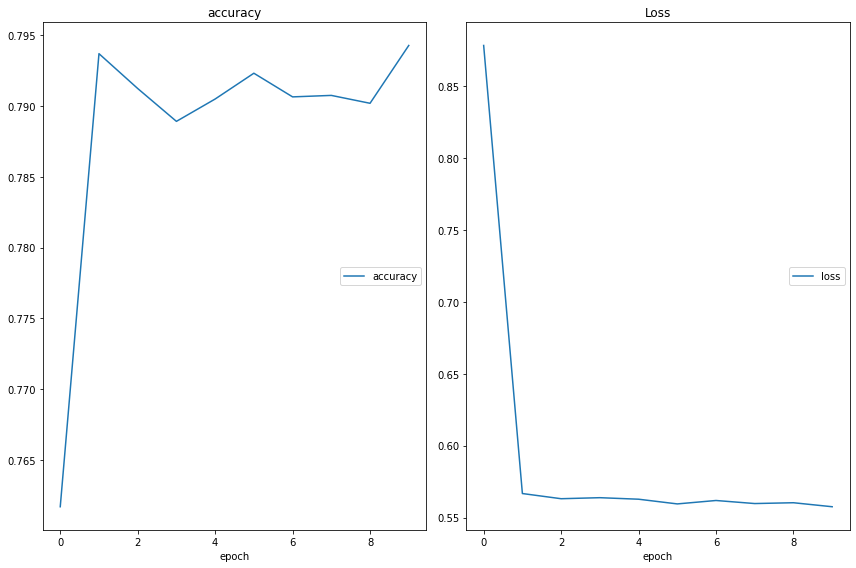

accuracy
	accuracy         	 (min:    0.762, max:    0.794, cur:    0.794)
Loss
	loss             	 (min:    0.558, max:    0.878, cur:    0.558)
75/75 [==============================] - 17s 233ms/step - loss: 0.5575 - accuracy: 0.7943


In [82]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback
early_stop= EarlyStopping(monitor='val_accuracy',patience=1,verbose=0,mode='max',restore_best_weights=False)
callbacks=[PlotLossesCallback(),early_stop]

history=model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, callbacks=callbacks)
# history=model.fit(X_train,y_train,batch_size=32,epochs=2,verbose=1,callbacks=callbacks)